Experiment 3: FIFA 20 Dataset from Kaggle

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set_theme()
import os

# sklearn
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# pytorch
import torch
from torch.optim import Adam
from torch import nn

# BERT from Huggingface
from transformers import BertTokenizer
from transformers import BertModel

# Extra additional packages/functions
from updated_balancers import BinaryBalancer
from utils import calculate_bias_metrics, eo_postprocess, calc_gen_bounds, BertClassifier, train, Dataset

In [2]:
# Import fifa 20 dataset
all_data = pd.read_csv('players_20.csv')
# all_data.head()

In [3]:
# Set the nationalities you want to use
nationalities = ['England','Argentina']

# Keep relevant columns
o_data = all_data[['long_name','age','nationality','overall','wage_eur']].copy(deep = True)

# Change column names of nationality and wage_eur to a and y 
o_data.rename(columns = {'nationality':'a', 'wage_eur':'y'}, inplace = True)

# Restrict to specified nationalities
o_data = o_data.loc[(o_data['a'].isin([nationalities[0], nationalities[1]]))]
print('Number of players:', o_data.shape[0])

# Only keep relevant feagires and outcomes
data = o_data[['long_name','age','a','overall','y']].copy(deep = True)

# Binarize nationality
data = data.replace(nationalities[0],0)
data = data.replace(nationalities[1],1)

# Reset the index
data = data.reset_index(drop=True)

# Binarize outcome using median outcome
data.loc[data['y'] < np.median(data['y']), 'y'] = 0
data.loc[data['y'] >= np.median(data['y']), 'y'] = 1
# data.head()

Number of players: 2553


In [4]:
# Create new column to stratify data and calculate base rates
group = []
for i in range(data.shape[0]):
    # w
    if np.sum(data[['a','y']].iloc[i] == [0,0]) == 2:
        group.append(1)
    # v
    if np.sum(data[['a','y']].iloc[i] == [1,0]) == 2:
        group.append(2)
    # s
    if np.sum(data[['a','y']].iloc[i] == [0,1]) == 2:
        group.append(3)
    # r
    if np.sum(data[['a','y']].iloc[i] == [1,1]) == 2:
        group.append(4)

# Add column to the data
data['group'] = group

# Calculate base rates
total = data.shape[0]
r = np.sum(data['group'] == 4)/total
s = np.sum(data['group'] == 3)/total
v = np.sum(data['group'] == 2)/total
w= np.sum(data['group'] == 1)/total
print('min rate = ', min(r,s,w,v))

min rate =  0.11711711711711711


In [5]:
# Experiment Parameters
EPOCHS = 10
model = BertClassifier()
LR = 1e-6 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# Splitting data into necessary datasets
d_xa, d_remain = train_test_split(data, train_size = 0.7, stratify=data['group'],random_state=10)

In [7]:
# Split d_xa into d_xa_train and d_xa_val
d_xa_train, d_xa_val = train_test_split(d_xa, train_size = 0.75, stratify=d_xa['group'],random_state=10)

# Train model
train(model, d_xa_train, d_xa_val, LR, EPOCHS)

100%|██████████| 670/670 [00:32<00:00, 20.55it/s]


Epochs: 1 | Train Loss:  0.540             | Train Accuracy:  0.745             | Val Loss:  0.323             | Val Accuracy:  0.944


100%|██████████| 670/670 [00:31<00:00, 21.13it/s]


Epochs: 2 | Train Loss:  0.271             | Train Accuracy:  0.949             | Val Loss:  0.199             | Val Accuracy:  0.964


100%|██████████| 670/670 [00:32<00:00, 20.42it/s]


Epochs: 3 | Train Loss:  0.185             | Train Accuracy:  0.963             | Val Loss:  0.164             | Val Accuracy:  0.962


100%|██████████| 670/670 [00:32<00:00, 20.48it/s]


Epochs: 4 | Train Loss:  0.132             | Train Accuracy:  0.975             | Val Loss:  0.154             | Val Accuracy:  0.957


100%|██████████| 670/670 [00:32<00:00, 20.59it/s]


Epochs: 5 | Train Loss:  0.110             | Train Accuracy:  0.975             | Val Loss:  0.146             | Val Accuracy:  0.962


100%|██████████| 670/670 [00:31<00:00, 21.09it/s]


Epochs: 6 | Train Loss:  0.089             | Train Accuracy:  0.984             | Val Loss:  0.150             | Val Accuracy:  0.960


100%|██████████| 670/670 [00:31<00:00, 21.10it/s]


Epochs: 7 | Train Loss:  0.075             | Train Accuracy:  0.986             | Val Loss:  0.145             | Val Accuracy:  0.962


100%|██████████| 670/670 [00:31<00:00, 21.11it/s]


Epochs: 8 | Train Loss:  0.059             | Train Accuracy:  0.989             | Val Loss:  0.154             | Val Accuracy:  0.960


100%|██████████| 670/670 [00:31<00:00, 21.12it/s]


Epochs: 9 | Train Loss:  0.050             | Train Accuracy:  0.993             | Val Loss:  0.147             | Val Accuracy:  0.962


100%|██████████| 670/670 [00:31<00:00, 21.08it/s]


Epochs: 10 | Train Loss:  0.039             | Train Accuracy:  0.992             | Val Loss:  0.162             | Val Accuracy:  0.957


Enforcing fairness

In [17]:
# Will repeatedly split data into
# d_xy_train
# d_xy_test
# d_xy_tune

bias_t_o = []
bias_f_o = []
bias_t_n = []
bias_f_n = []
u_bound_t_o = []
l_bound_t_o = []
u_bound_f_o = []
l_bound_f_o = []
u_bound_t_n = []
l_bound_t_n = []
u_bound_f_n = []
l_bound_f_n = []

new_bias_h_t = []
new_bias_h_f = []

for i in tqdm(range(100)):
    d_xy_train, d_xy_test = train_test_split(d_remain, train_size = 0.7, stratify=d_remain['group'])
    # d_xy_test, d_xay = train_test_split(d_xy_remain, train_size = 0.95, stratify=d_xy_remain['group'])

    # Create Classifier
    clf = RandomForestClassifier(n_estimators=50)

    # Split data into features and labels
    x_train = d_xy_train[['age','overall']]
    y_train = d_xy_train['y']
    x_test = d_xy_test[['age','overall']]
    y_test = d_xy_test['y']

    # Fit classifier
    clf.fit(x_train.to_numpy(),y_train)

    # Model Accuracy:
    # print("Accuracy:", metrics.accuracy_score(y_test, clf.predict(x_test.to_numpy())))

    # Evaluate probabilities/y_hat on test set
    y_prob = clf.predict_proba(x_test.to_numpy())
    
    # Add y_prob/y_hat to data
    d_xy_test['y_prob'] = y_prob[:,1]
    d_xy_test['y_hat'] = (y_prob[:,1] >= 0.5)
    d_xy_test['y_hat'] = y_prob[:,1]

    # Calculate bias metrics with respect to a
    alpha, beta, tau, phi = calculate_bias_metrics(d_xy_test)
    bias_t_o.append(alpha - beta)
    bias_f_o.append(tau - phi)

    # Calculating a_hat using the trained BERT model
    xy_test = Dataset(d_xy_test)
    xy_test_dataloader = torch.utils.data.DataLoader(xy_test, batch_size=len(xy_test))
    device = torch.device("cpu")
    model.to(device)
    model = model.eval()
    with torch.no_grad():
        for xy_test_input, xy_test_label, xy_test_remain in xy_test_dataloader:
            xy_test_label = xy_test_label.to(device).float()
            mask = xy_test_input['attention_mask'].to(device)
            input_id = xy_test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask).reshape(1,-1)[0]
    
    # Replace a column with a_hat to data
    a_true = d_xy_test['a']
    d_xy_test['a'] = (output >= 0.5)
    a_error = np.sum(d_xy_test['a'] != a_true)/d_xy_test.shape[0]

    # Computing upper and lower bounds
    alpha_hat, beta_hat, tau_hat, phi_hat = calculate_bias_metrics(d_xy_test)
    ub_t_o, lb_t_o = calc_gen_bounds(alpha_hat,beta_hat,a_error,r,s)
    ub_f_o, lb_f_o = calc_gen_bounds(tau_hat,phi_hat,a_error,v,w)
    u_bound_t_o.append(ub_t_o)
    l_bound_t_o.append(lb_t_o)
    u_bound_f_o.append(ub_f_o)
    l_bound_f_o.append(lb_f_o)

    '''
    # Using d_xay to learn a fair f wrt to a_hat

    # Evaluate probabilities/y_hat on d_xay set
    y_prob = clf.predict_proba(d_xay[['age','overall']].to_numpy())
    
    # Add y_prob/y_hat to data
    d_xay['y_prob'] = y_prob[:,1]
    d_xay['y_hat'] = (y_prob[:,1] >= 0.5)

    # Calculating a_hat using the trained BERT model
    xay = Dataset(d_xay)
    xay_dataloader = torch.utils.data.DataLoader(xay, batch_size=len(xay))
    device = torch.device("cpu")
    model.to(device)
    model = model.eval()
    with torch.no_grad():
        for xay_input, xay_label, xay_remain in xay_dataloader:
            xay_label = xay_label.to(device).float()
            mask = xay_input['attention_mask'].to(device)
            input_id = xay_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask).reshape(1,-1)[0]

    # Replace a column with a_hat to data
    d_xay['a'] = np.array((output >= 0.5)).astype('float')
    # a_error = np.sum(d_xy_test['a'] != d_xy_test['nationality'])/d_xy_test.shape[0]
    '''

    # Learn fair f
    _, fair_model = eo_postprocess(d_xy_test)

    # Calculate new bias_estimates
    df_ah_fair = d_xy_test.copy(deep = True)
    df_ah_fair.y_hat = fair_model.predict(d_xy_test.y_prob.values,d_xy_test.a.values)

    # Calculate est bias_tpr and bias_fpr
    alpha_hat_f, beta_hat_f, tau_hat_f, phi_hat_f = calculate_bias_metrics(df_ah_fair)
    new_bias_h_t.append(alpha_hat_f - beta_hat_f)
    new_bias_h_f.append(tau_hat_f - phi_hat_f)

    # Computing the new upper bound and lower bounds under the assumption
    ub_t_n, lb_t_n = calc_gen_bounds(alpha_hat_f,beta_hat_f,a_error,r,s)
    ub_f_n, lb_f_n = calc_gen_bounds(tau_hat_f,phi_hat_f,a_error,v,w)
    l_bound_t_n.append(lb_t_n)
    l_bound_f_n.append(lb_f_n)
    u_bound_t_n.append(ub_t_n)
    u_bound_f_n.append(ub_f_n)

    # Calculate new true bias wrt to a with fair f
    d_xy_test['a'] = a_true
    yh_fair = fair_model.predict(d_xy_test.y_prob.values,d_xy_test.a.values)
    df_fair = d_xy_test.copy(deep=True)
    df_fair.y_hat = yh_fair
    alpha_n, beta_n, tau_n, phi_n = calculate_bias_metrics(df_fair)

    # New bias
    bias_t_n.append(alpha_n - beta_n)
    bias_f_n.append(tau_n - phi_n)

100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


In [18]:
# Computing max distributions
indices = ((np.abs(new_bias_h_t) <= 0.05).astype('float') + (np.abs(new_bias_h_f) <= 0.05).astype('float')) == 2
max_t_o = np.maximum(np.abs(u_bound_t_o)[indices],np.abs(l_bound_t_o)[indices])
max_t_n = np.maximum(np.abs(u_bound_t_n)[indices],np.abs(l_bound_t_n)[indices])
max_f_o = np.maximum(np.abs(u_bound_f_o)[indices],np.abs(l_bound_f_o)[indices])
max_f_n = np.maximum(np.abs(u_bound_f_n)[indices],np.abs(l_bound_f_n)[indices])

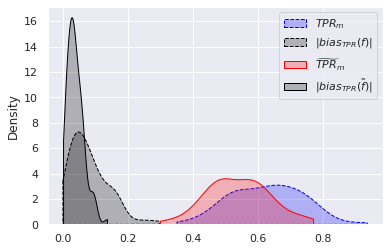

In [19]:
# Kde plots: Upper bound
sns.kdeplot(max_t_o,shade=True, cut = 0, label = '$TPR_{m}$',linestyle='--', color = 'blue')
sns.kdeplot(np.array(np.abs(bias_t_o)[indices]), shade = True, cut=0, label = r'$|bias_{TPR}(f)|$', color = 'black', linestyle='--')
sns.kdeplot(max_t_n,shade=True, cut = 0,label = r'$\widetilde{TPR}_{m}$', color = 'red')
sns.kdeplot(np.array(np.abs(bias_t_n)[indices]),shade=True, cut = 0, label = r'$|bias_{TPR}(\tilde{f})|$',color='black')
plt.legend()
# plt.savefig('Figures/Exp3/real_data_tpr_control_germany_england.png',bbox_inches="tight")

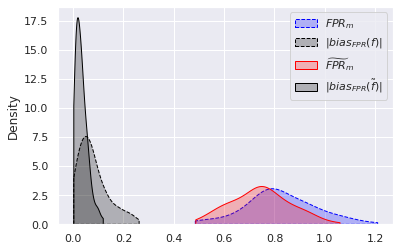

In [20]:
# Kde plots: Upper bound
sns.kdeplot(max_f_o,shade=True, cut = 0, label = '$FPR_{m}$',linestyle='--', color = 'blue')
sns.kdeplot(np.array(np.abs(bias_f_o))[indices], shade = True, cut=0, label = r'$|bias_{FPR}(f)|$', color = 'black', linestyle='--')
sns.kdeplot(max_f_n,shade=True, cut = 0,label = r'$\widetilde{FPR}_{m}$', color = 'red')
sns.kdeplot(np.array(np.abs(bias_f_n)[indices]),shade=True, cut = 0, label = r'$|bias_{FPR}(\tilde{f})|$',color='black')
plt.legend()
# plt.savefig('Figures/Exp3/real_data_fpr_control_germany_england.png',bbox_inches="tight")